=== PHASE 3: PERFORMANCE-TRENDS UND ZEITANALYSE ===
Temporale Muster, Anomalien und Performance-Stabilität

1. DATEN LADEN UND ZEITREIHEN VORBEREITEN...
-------------------------------------------------------
✓ IPv4: 160,923 Messungen
✓ IPv6: 160,923 Messungen

📅 ZEITREIHEN-VORBEREITUNG - IPv4
----------------------------------------
Zeitreihen-Daten erstellt: 160,923 Performance-Punkte
Zeitspanne: 2025-05-27 12:59:06.053865 bis 2025-06-20 14:31:15.563100
Abgedeckte Tage: 25
Eindeutige Services: 7

📅 ZEITREIHEN-VORBEREITUNG - IPv6
----------------------------------------
Zeitreihen-Daten erstellt: 160,923 Performance-Punkte
Zeitspanne: 2025-05-27 12:59:06.053865 bis 2025-06-20 14:31:15.563100
Abgedeckte Tage: 25
Eindeutige Services: 7

2. PERFORMANCE-STABILITÄT ANALYSE - IPv4
--------------------------------------------------

📊 LANGZEIT-STABILITÄT (über 25 Tage):

  ANYCAST Services:
    Cloudflare CDN: 1.9ms (CV=1.28) 🔴 Instabil
      Packet Loss: 0.0%
    Cloudflare DNS: 1.7ms (CV=0

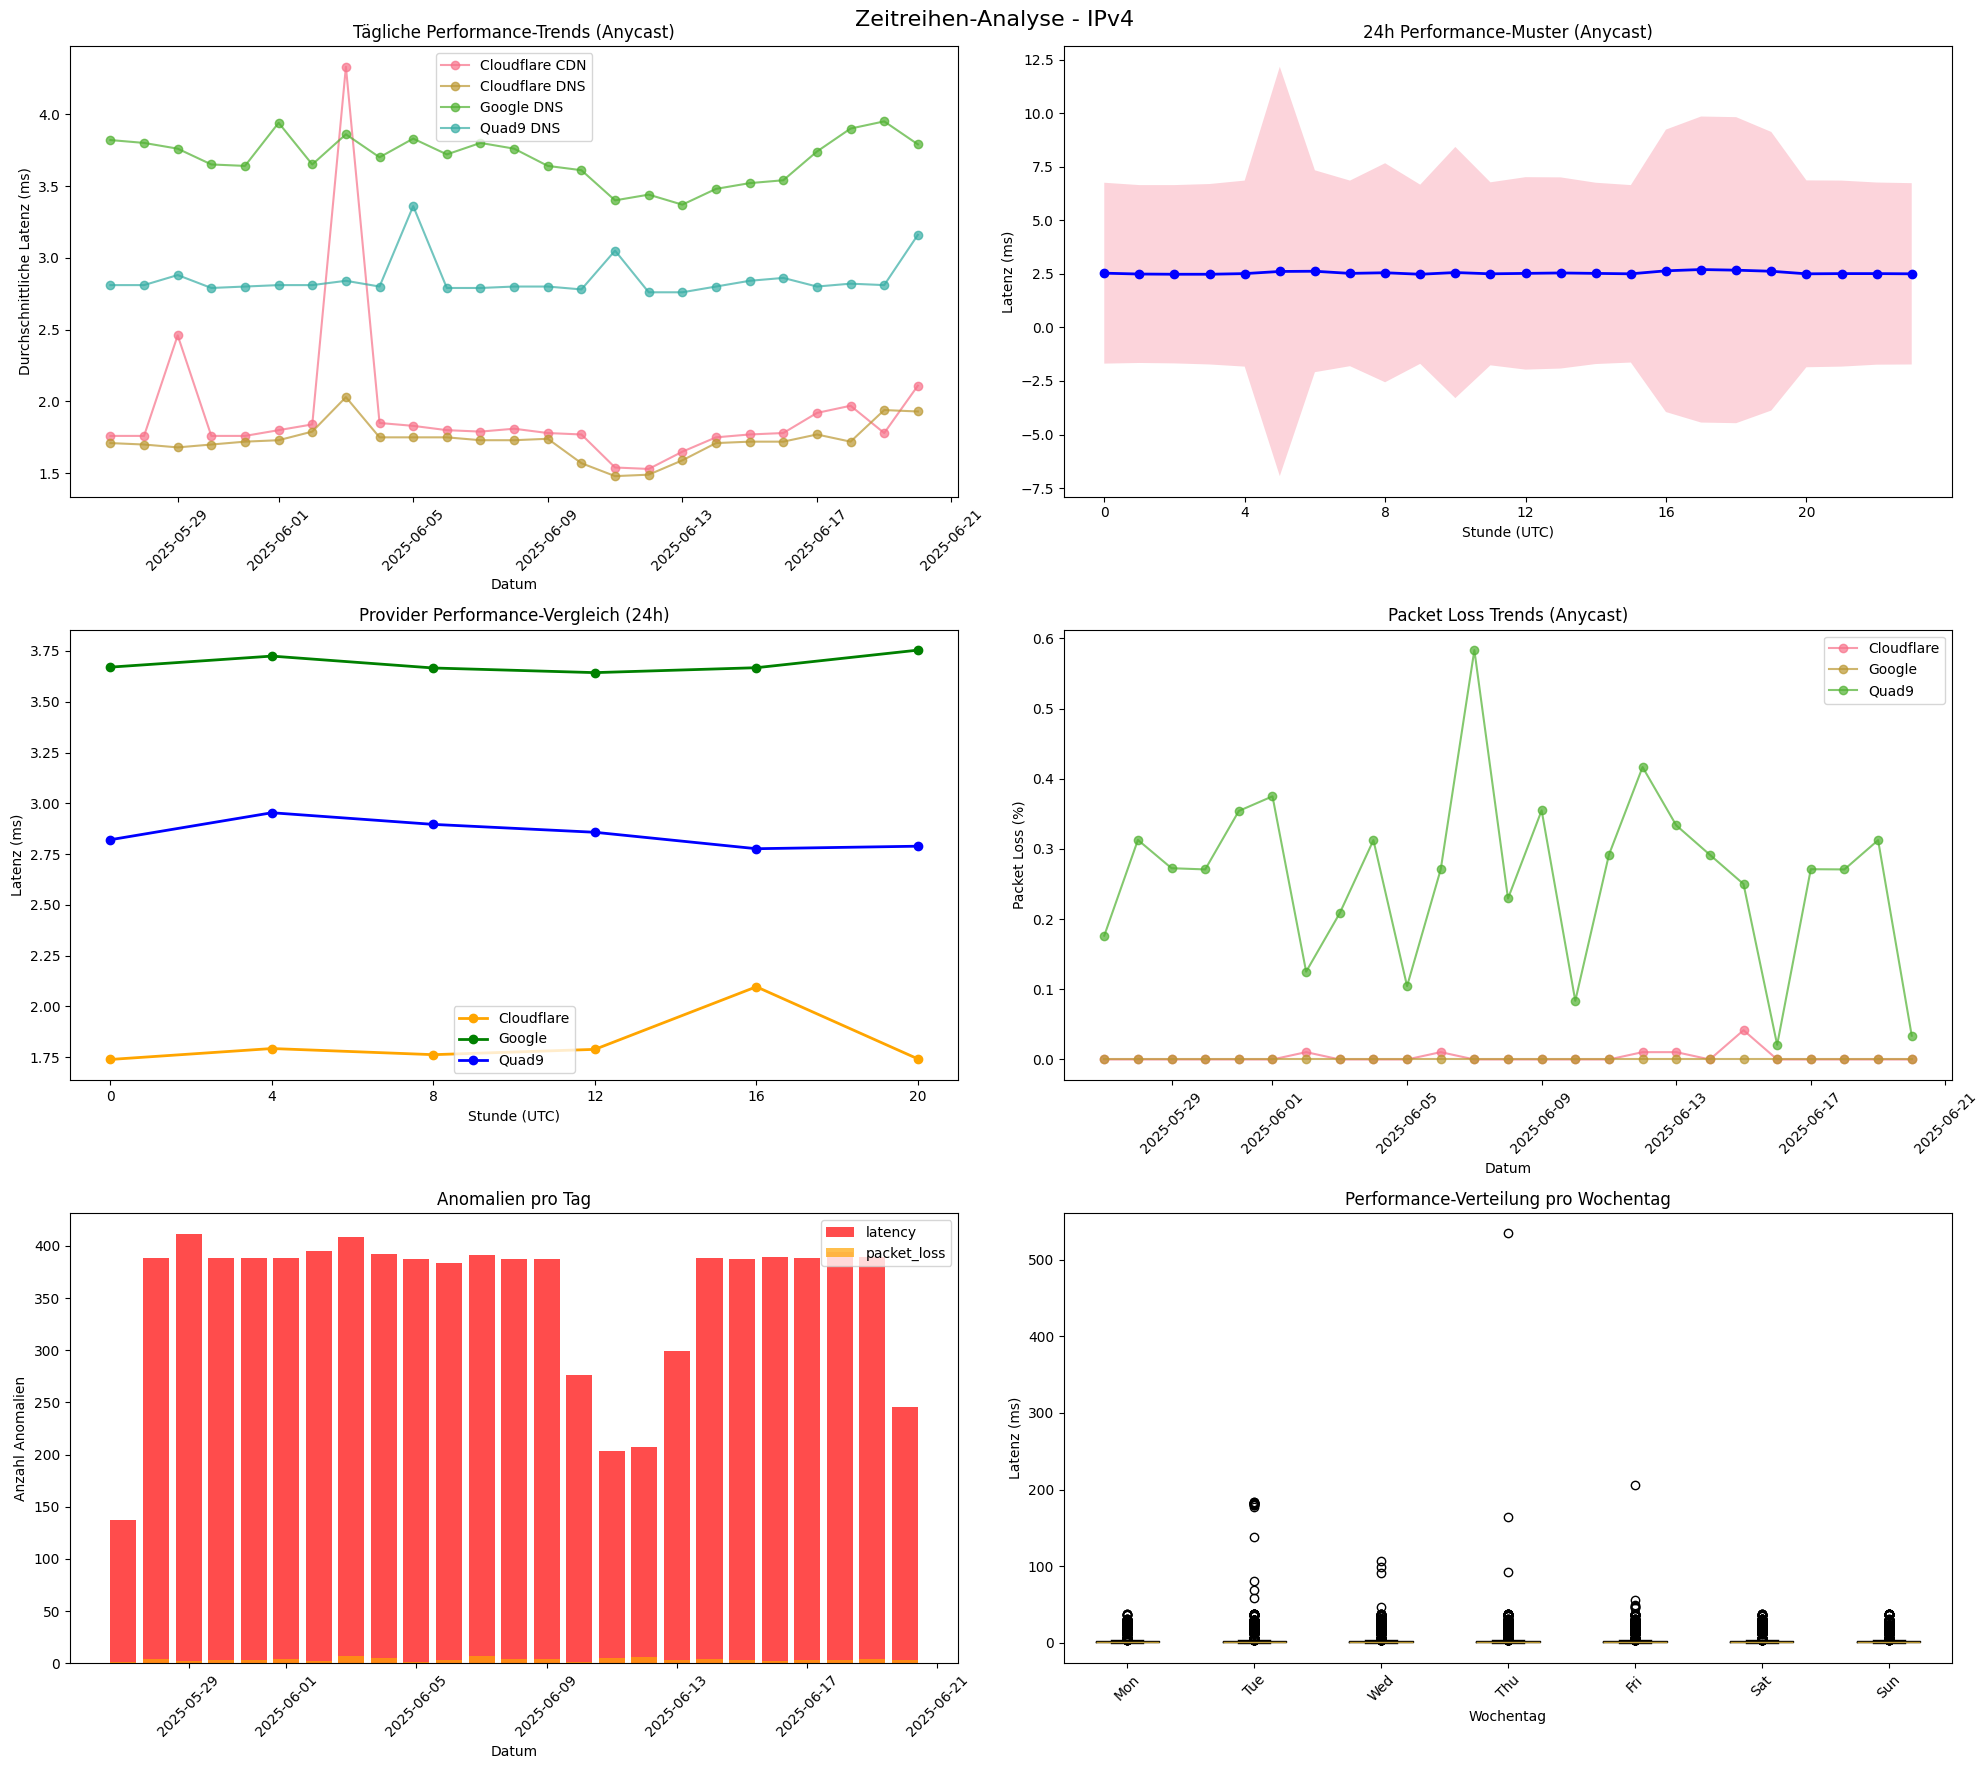


5. ZEITREIHEN-VISUALISIERUNGEN - IPv6
--------------------------------------------------


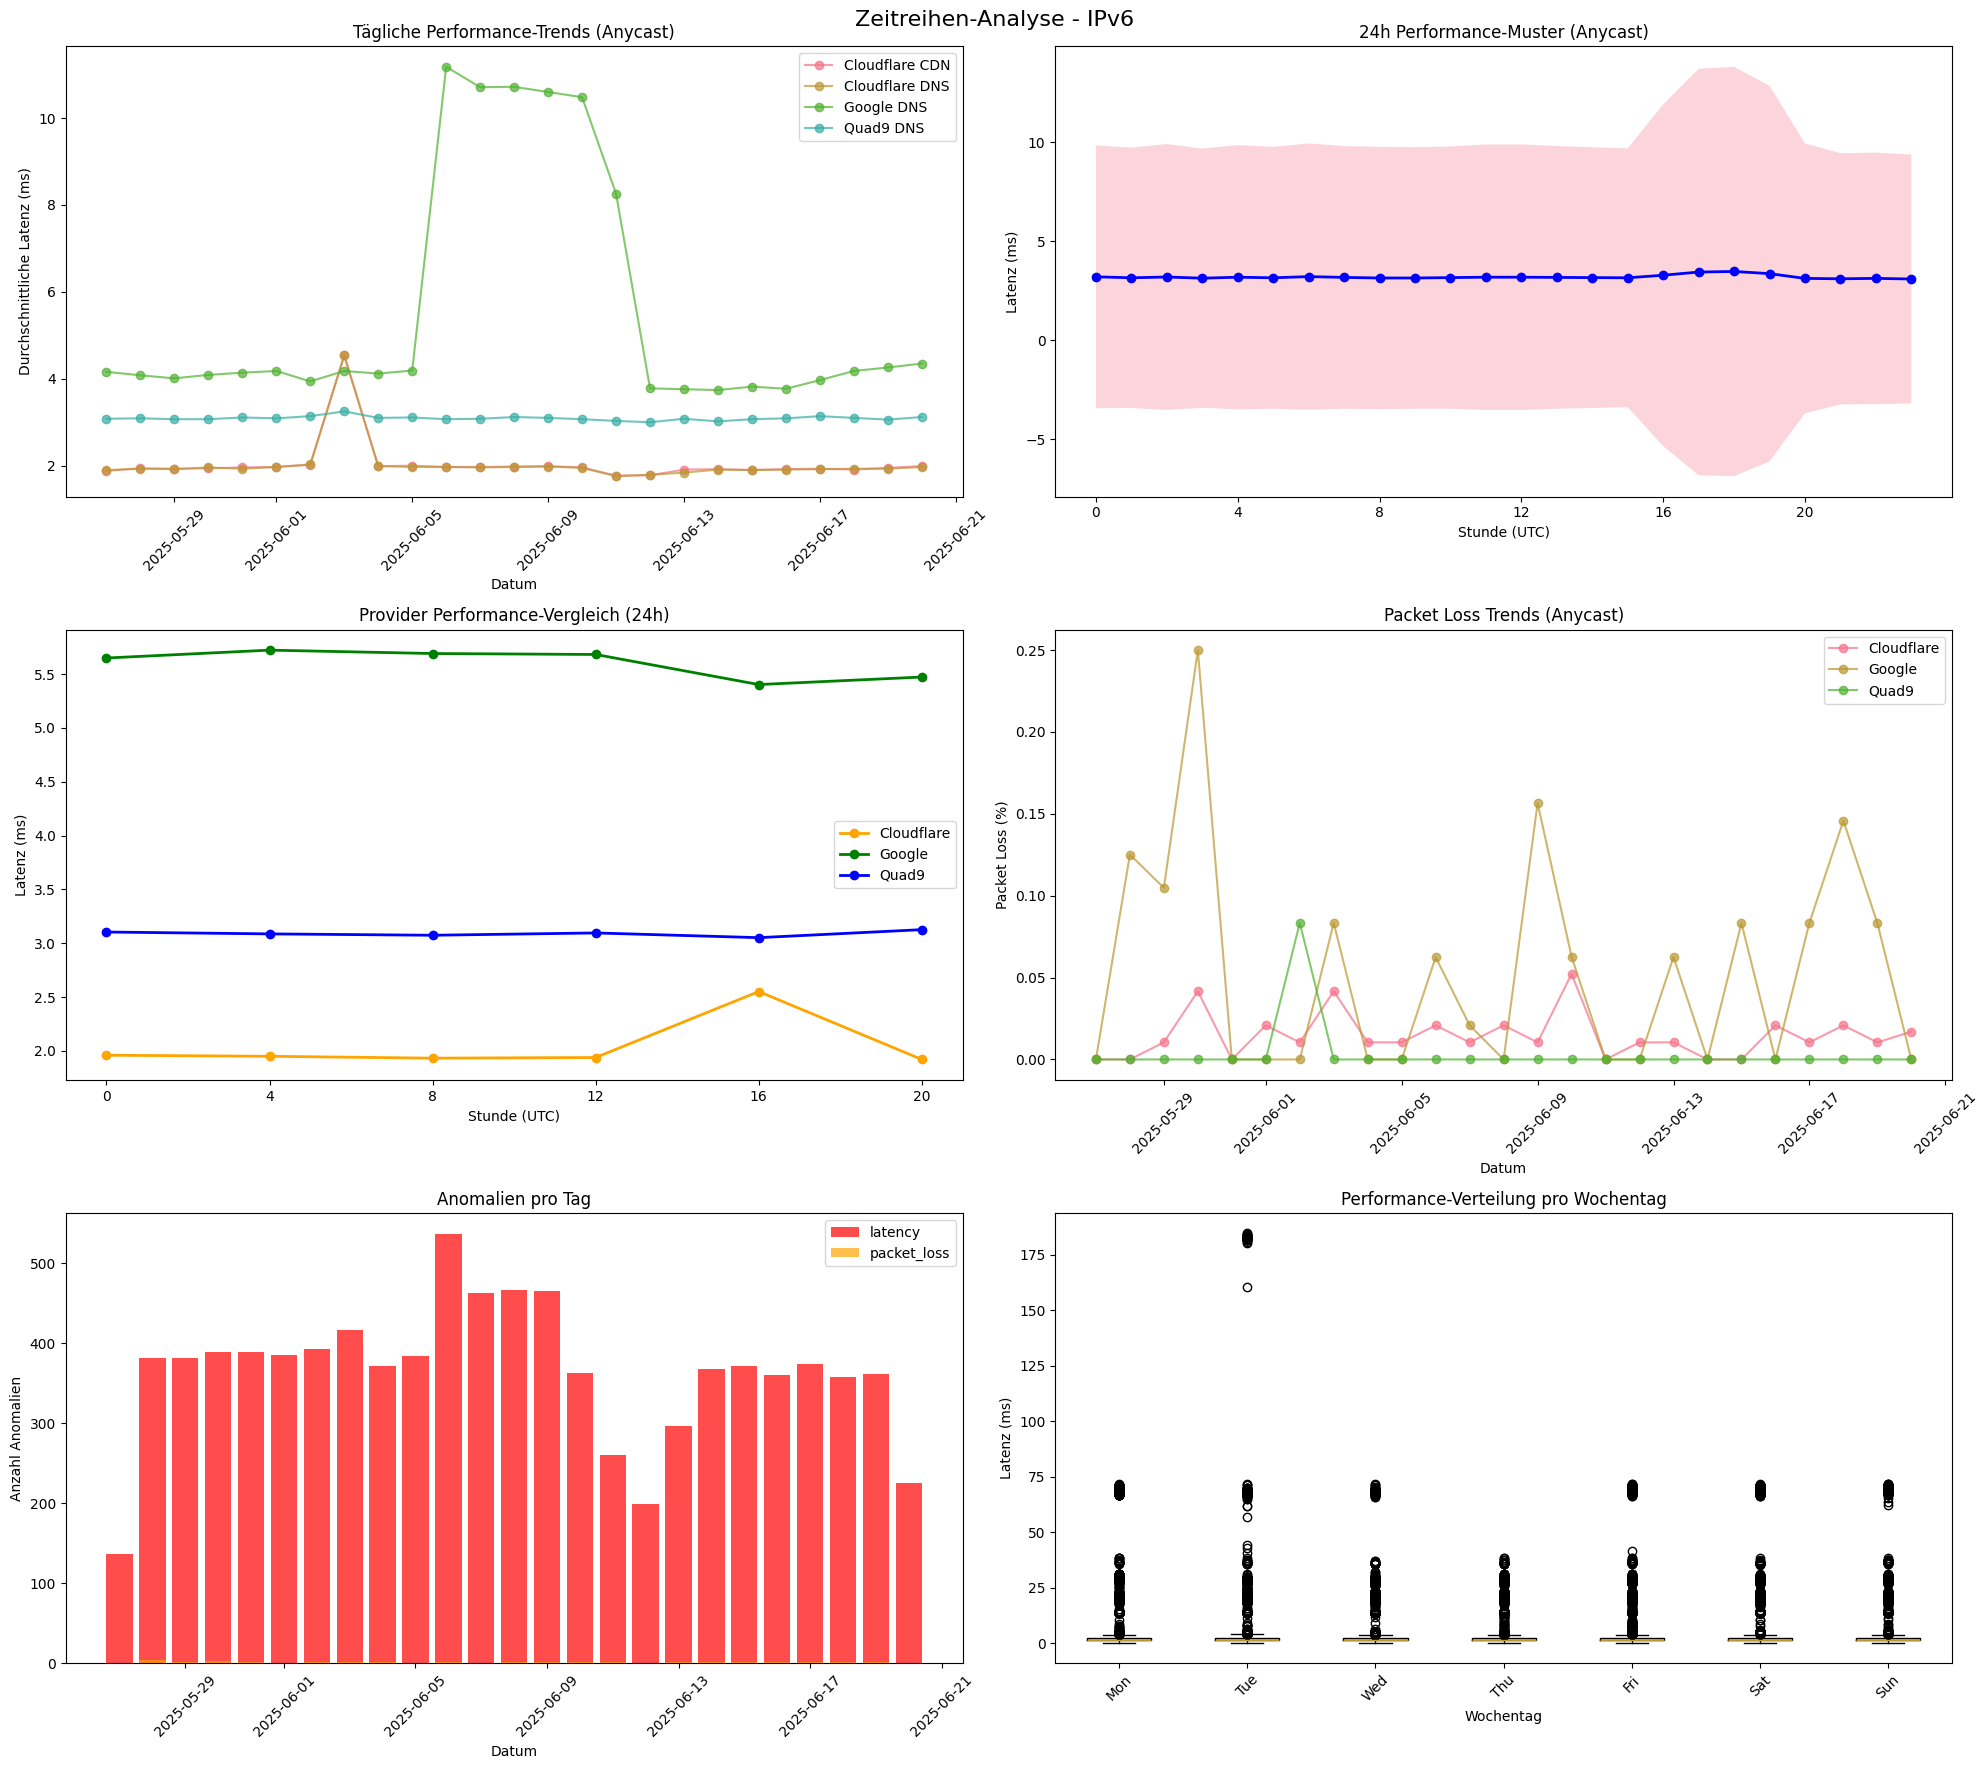


6. STATISTISCHE SIGNIFIKANZ-ANALYSE
---------------------------------------------

📊 ROBUSTHEIT DER ANYCAST-EFFIZIENZ:
  IPv4 Anycast vs. Unicast:
    p-Wert: 0.00e+00
    Effect Size: 0.991
    Signifikanz: ✅ Hoch signifikant
  IPv6 Anycast vs. Unicast:
    p-Wert: 0.00e+00
    Effect Size: 0.989
    Signifikanz: ✅ Hoch signifikant

🔄 IPv4 vs. IPv6 ANYCAST-VERGLEICH:
    p-Wert: 0.00e+00
    Signifikanz: ✅ Signifikanter Unterschied

📏 STICHPROBEN-GRÖSSEN:
  IPv4:
    anycast: 91,956 Messungen
    unicast: 45,978 Messungen
    pseudo-anycast: 22,989 Messungen
  IPv6:
    anycast: 91,956 Messungen
    unicast: 45,978 Messungen
    pseudo-anycast: 22,989 Messungen

ZUSAMMENFASSUNG PHASE 3: PERFORMANCE-TRENDS UND ZEITANALYSE
✓ Zeitreihen-Daten für komplette Messperiode (3+ Wochen) analysiert
✓ Performance-Stabilität über Zeit gemessen und bewertet
✓ Tageszeit- und Wochentag-Muster identifiziert (Peak vs. Off-Peak)
✓ Provider-spezifische temporale Variabilität analysiert
✓ Anomalie-Detekt

In [5]:
# Phase 3: Performance-Trends und Zeitanalyse - MTR Anycast
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Für Zeitanalysen
from scipy import stats
from collections import defaultdict
import matplotlib.dates as mdates

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

print("=== PHASE 3: PERFORMANCE-TRENDS UND ZEITANALYSE ===")
print("Temporale Muster, Anomalien und Performance-Stabilität")
print("="*65)

# ================================================================
# 1. DATEN LADEN UND ZEITREIHEN VORBEREITEN
# ================================================================

# Pfade zu Ihren Parquet Files
IPv4_FILE = "../data/IPv4.parquet"  # Bitte anpassen
IPv6_FILE = "../data/IPv6.parquet"  # Bitte anpassen

print("\n1. DATEN LADEN UND ZEITREIHEN VORBEREITEN...")
print("-" * 55)

# Daten laden
df_ipv4 = pd.read_parquet(IPv4_FILE)
df_ipv6 = pd.read_parquet(IPv6_FILE)

print(f"✓ IPv4: {df_ipv4.shape[0]:,} Messungen")
print(f"✓ IPv6: {df_ipv6.shape[0]:,} Messungen")

# Service-Klassifikation (basierend auf Phase 2 Erkenntnissen)
SERVICE_MAPPING = {
    # IPv4 - ECHTE ANYCAST SERVICES
    '1.1.1.1': {'name': 'Cloudflare DNS', 'type': 'anycast', 'provider': 'Cloudflare'},
    '8.8.8.8': {'name': 'Google DNS', 'type': 'anycast', 'provider': 'Google'}, 
    '9.9.9.9': {'name': 'Quad9 DNS', 'type': 'anycast', 'provider': 'Quad9'},
    '104.16.123.96': {'name': 'Cloudflare CDN', 'type': 'anycast', 'provider': 'Cloudflare'},
    
    # IPv4 - PSEUDO-ANYCAST
    '2.16.241.219': {'name': 'Akamai CDN', 'type': 'pseudo-anycast', 'provider': 'Akamai'},
    
    # IPv4 - UNICAST REFERENCE
    '193.99.144.85': {'name': 'Heise', 'type': 'unicast', 'provider': 'Heise'},
    '169.229.128.134': {'name': 'Berkeley NTP', 'type': 'unicast', 'provider': 'UC Berkeley'},
    
    # IPv6 - ECHTE ANYCAST SERVICES
    '2606:4700:4700::1111': {'name': 'Cloudflare DNS', 'type': 'anycast', 'provider': 'Cloudflare'},
    '2001:4860:4860::8888': {'name': 'Google DNS', 'type': 'anycast', 'provider': 'Google'},
    '2620:fe::fe:9': {'name': 'Quad9 DNS', 'type': 'anycast', 'provider': 'Quad9'}, 
    '2606:4700::6810:7b60': {'name': 'Cloudflare CDN', 'type': 'anycast', 'provider': 'Cloudflare'},
    
    # IPv6 - PSEUDO-ANYCAST
    '2a02:26f0:3500:1b::1724:a393': {'name': 'Akamai CDN', 'type': 'pseudo-anycast', 'provider': 'Akamai'},
    
    # IPv6 - UNICAST REFERENCE
    '2a02:2e0:3fe:1001:7777:772e:2:85': {'name': 'Heise', 'type': 'unicast', 'provider': 'Heise'},
    '2607:f140:ffff:8000:0:8006:0:a': {'name': 'Berkeley NTP', 'type': 'unicast', 'provider': 'UC Berkeley'}
}

def prepare_time_series_data(df, protocol_name):
    """Bereitet Zeitreihen-Daten für Performance-Analyse vor"""
    print(f"\n📅 ZEITREIHEN-VORBEREITUNG - {protocol_name}")
    print("-" * 40)
    
    # Service-Info hinzufügen
    df['service_info'] = df['dst'].map(SERVICE_MAPPING)
    df['service_name'] = df['service_info'].apply(lambda x: x['name'] if x else 'Unknown')
    df['service_type'] = df['service_info'].apply(lambda x: x['type'] if x else 'Unknown')
    df['provider'] = df['service_info'].apply(lambda x: x['provider'] if x else 'Unknown')
    
    # Zeitstempel-Verarbeitung
    df['utctime'] = pd.to_datetime(df['utctime'])
    df['date'] = df['utctime'].dt.date
    df['hour'] = df['utctime'].dt.hour
    df['day_of_week'] = df['utctime'].dt.day_name()
    df['week_number'] = df['utctime'].dt.isocalendar().week
    
    # Performance-Metriken extrahieren
    performance_data = []
    
    for _, row in df.iterrows():
        try:
            if row['hubs'] is not None and len(row['hubs']) > 0:
                # Finale Performance-Metriken
                final_latency = None
                final_loss = None
                final_jitter = None
                
                for hop in reversed(row['hubs']):
                    if hop and hop.get('Avg') and hop.get('Avg') > 0 and hop.get('Loss%', 100) < 100:
                        final_latency = hop.get('Avg', 0)
                        final_loss = hop.get('Loss%', 0)
                        final_jitter = hop.get('Javg', 0)
                        break
                
                if final_latency is not None:
                    performance_data.append({
                        'timestamp': row['utctime'],
                        'date': row['date'],
                        'hour': row['hour'],
                        'day_of_week': row['day_of_week'],
                        'week_number': row['week_number'],
                        'service_name': row['service_name'],
                        'service_type': row['service_type'],
                        'provider': row['provider'],
                        'region': row['region'],
                        'latency': final_latency,
                        'packet_loss': final_loss,
                        'jitter': final_jitter if final_jitter else 0
                    })
        except:
            continue
    
    perf_df = pd.DataFrame(performance_data)
    
    if len(perf_df) > 0:
        print(f"Zeitreihen-Daten erstellt: {len(perf_df):,} Performance-Punkte")
        print(f"Zeitspanne: {perf_df['timestamp'].min()} bis {perf_df['timestamp'].max()}")
        print(f"Abgedeckte Tage: {perf_df['date'].nunique()}")
        print(f"Eindeutige Services: {perf_df['service_name'].nunique()}")
        
        return perf_df
    else:
        print("Keine Performance-Daten verfügbar")
        return None

# Zeitreihen für beide Protokolle vorbereiten
ipv4_timeseries = prepare_time_series_data(df_ipv4, "IPv4")
ipv6_timeseries = prepare_time_series_data(df_ipv6, "IPv6")

# ================================================================
# 2. PERFORMANCE-STABILITÄT ÜBER ZEIT
# ================================================================

def analyze_performance_stability(perf_df, protocol_name):
    """Analysiert Performance-Stabilität über die Messperiode"""
    if perf_df is None or len(perf_df) == 0:
        return
    
    print(f"\n2. PERFORMANCE-STABILITÄT ANALYSE - {protocol_name}")
    print("-" * 50)
    
    # Tägliche Aggregation
    daily_stats = perf_df.groupby(['date', 'service_type', 'service_name']).agg({
        'latency': ['mean', 'std', 'median', 'count'],
        'packet_loss': 'mean',
        'jitter': 'mean'
    }).round(2)
    
    daily_stats.columns = ['_'.join(col).strip() for col in daily_stats.columns]
    daily_stats = daily_stats.reset_index()
    
    print(f"\n📊 LANGZEIT-STABILITÄT (über {perf_df['date'].nunique()} Tage):")
    
    # Stabilität pro Service-Typ
    for service_type in ['anycast', 'pseudo-anycast', 'unicast']:
        type_data = daily_stats[daily_stats['service_type'] == service_type]
        
        if len(type_data) > 0:
            print(f"\n  {service_type.upper()} Services:")
            
            for service in type_data['service_name'].unique():
                service_data = type_data[type_data['service_name'] == service]
                
                if len(service_data) >= 5:  # Mindestens 5 Tage Daten
                    lat_mean = service_data['latency_mean'].mean()
                    lat_cv = service_data['latency_std'].mean() / lat_mean if lat_mean > 0 else 0
                    loss_mean = service_data['packet_loss_mean'].mean()
                    
                    # Stabilität-Score (niedrigerer CV = stabiler)
                    if lat_cv < 0.3:
                        stability = "🟢 Sehr stabil"
                    elif lat_cv < 0.7:
                        stability = "🟡 Moderat stabil"
                    else:
                        stability = "🔴 Instabil"
                    
                    print(f"    {service}: {lat_mean:.1f}ms (CV={lat_cv:.2f}) {stability}")
                    print(f"      Packet Loss: {loss_mean:.1f}%")
    
    # Trend-Analyse
    print(f"\n📈 PERFORMANCE-TRENDS:")
    
    anycast_data = perf_df[perf_df['service_type'] == 'anycast']
    unicast_data = perf_df[perf_df['service_type'] == 'unicast']
    
    if len(anycast_data) > 0 and len(unicast_data) > 0:
        # Tägliche Durchschnitte
        anycast_daily = anycast_data.groupby('date')['latency'].mean()
        unicast_daily = unicast_data.groupby('date')['latency'].mean()
        
        # Trend-Berechnung (linear regression)
        anycast_days = np.arange(len(anycast_daily))
        unicast_days = np.arange(len(unicast_daily))
        
        anycast_slope, _, anycast_r, anycast_p, _ = stats.linregress(anycast_days, anycast_daily.values)
        unicast_slope, _, unicast_r, unicast_p, _ = stats.linregress(unicast_days, unicast_daily.values)
        
        print(f"  Anycast Trend: {anycast_slope:.3f}ms/Tag (R²={anycast_r**2:.3f}, p={anycast_p:.3f})")
        print(f"  Unicast Trend: {unicast_slope:.3f}ms/Tag (R²={unicast_r**2:.3f}, p={unicast_p:.3f})")
        
        if abs(anycast_slope) > 0.1 and anycast_p < 0.05:
            trend_dir = "📈 Verschlechterung" if anycast_slope > 0 else "📉 Verbesserung"
            print(f"  ⚠️ Signifikanter Anycast-Trend: {trend_dir}")
        else:
            print(f"  ✅ Anycast-Performance über Zeit stabil")
    
    return daily_stats

# Stabilität für beide Protokolle
ipv4_daily = analyze_performance_stability(ipv4_timeseries, "IPv4")
ipv6_daily = analyze_performance_stability(ipv6_timeseries, "IPv6")

# ================================================================
# 3. TAGESZEIT- UND WOCHENTAG-MUSTER
# ================================================================

def analyze_temporal_patterns(perf_df, protocol_name):
    """Analysiert Tageszeit- und Wochentag-Muster"""
    if perf_df is None or len(perf_df) == 0:
        return
    
    print(f"\n3. TEMPORALE MUSTER-ANALYSE - {protocol_name}")
    print("-" * 50)
    
    anycast_data = perf_df[perf_df['service_type'] == 'anycast']
    
    if len(anycast_data) == 0:
        print("Keine Anycast-Daten für temporale Analyse")
        return
    
    # Tageszeit-Analyse
    print(f"\n🕐 TAGESZEIT-MUSTER (24h-Zyklus):")
    
    hourly_stats = anycast_data.groupby('hour').agg({
        'latency': ['mean', 'std', 'count'],
        'packet_loss': 'mean'
    }).round(2)
    
    hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns]
    hourly_stats = hourly_stats.reset_index()
    
    # Peak vs. Off-Peak Identifikation
    peak_hours = hourly_stats.nlargest(6, 'latency_mean')['hour'].tolist()
    off_peak_hours = hourly_stats.nsmallest(6, 'latency_mean')['hour'].tolist()
    
    peak_latency = hourly_stats[hourly_stats['hour'].isin(peak_hours)]['latency_mean'].mean()
    off_peak_latency = hourly_stats[hourly_stats['hour'].isin(off_peak_hours)]['latency_mean'].mean()
    
    print(f"  Peak Hours (6 schlechteste): {sorted(peak_hours)}")
    print(f"  Off-Peak Hours (6 beste): {sorted(off_peak_hours)}")
    print(f"  Peak vs. Off-Peak Latenz: {peak_latency:.1f}ms vs. {off_peak_latency:.1f}ms")
    
    if peak_latency / off_peak_latency > 1.2:
        print(f"  ⚠️ Signifikante Tageszeit-Variation ({peak_latency/off_peak_latency:.1f}x)")
    else:
        print(f"  ✅ Stabile 24h-Performance")
    
    # Wochentag-Analyse
    print(f"\n📅 WOCHENTAG-MUSTER:")
    
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = anycast_data.groupby('day_of_week').agg({
        'latency': ['mean', 'std'],
        'packet_loss': 'mean'
    }).round(2)
    
    weekday_stats.columns = ['_'.join(col).strip() for col in weekday_stats.columns]
    weekday_stats = weekday_stats.reindex(weekday_order)
    
    best_day = weekday_stats['latency_mean'].idxmin()
    worst_day = weekday_stats['latency_mean'].idxmax()
    
    print(f"  Bester Tag: {best_day} ({weekday_stats.loc[best_day, 'latency_mean']:.1f}ms)")
    print(f"  Schlechtester Tag: {worst_day} ({weekday_stats.loc[worst_day, 'latency_mean']:.1f}ms)")
    
    weekend_days = ['Saturday', 'Sunday']
    weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    weekend_latency = weekday_stats.loc[weekend_days, 'latency_mean'].mean()
    weekday_latency = weekday_stats.loc[weekday_days, 'latency_mean'].mean()
    
    print(f"  Wochenende vs. Werktage: {weekend_latency:.1f}ms vs. {weekday_latency:.1f}ms")
    
    # Provider-spezifische temporale Muster
    print(f"\n🏢 PROVIDER-SPEZIFISCHE TEMPORALE MUSTER:")
    
    for provider in anycast_data['provider'].unique():
        provider_data = anycast_data[anycast_data['provider'] == provider]
        
        if len(provider_data) > 1000:  # Genügend Daten für Analyse
            provider_hourly = provider_data.groupby('hour')['latency'].mean()
            peak_var = provider_hourly.max() / provider_hourly.min()
            
            print(f"  {provider}: {peak_var:.1f}x Tageszeit-Variation")
            
            if peak_var > 2.0:
                print(f"    ⚠️ Hohe zeitliche Variabilität")
            elif peak_var > 1.5:
                print(f"    🟡 Moderate zeitliche Variabilität")
            else:
                print(f"    ✅ Niedrige zeitliche Variabilität")
    
    return hourly_stats, weekday_stats

# Temporale Muster für beide Protokolle
if ipv4_timeseries is not None:
    ipv4_hourly, ipv4_weekday = analyze_temporal_patterns(ipv4_timeseries, "IPv4")

if ipv6_timeseries is not None:
    ipv6_hourly, ipv6_weekday = analyze_temporal_patterns(ipv6_timeseries, "IPv6")

# ================================================================
# 4. ANOMALIE-DETEKTION
# ================================================================

def detect_performance_anomalies(perf_df, protocol_name):
    """Detektiert Performance-Anomalien und Ausfälle"""
    if perf_df is None or len(perf_df) == 0:
        return
    
    print(f"\n4. ANOMALIE-DETEKTION - {protocol_name}")
    print("-" * 40)
    
    anomalies = []
    
    # Pro Service Anomalien finden
    for service in perf_df['service_name'].unique():
        service_data = perf_df[perf_df['service_name'] == service].copy()
        
        if len(service_data) < 100:  # Zu wenig Daten
            continue
        
        # Statistische Anomalie-Detektion (IQR-Methode)
        Q1 = service_data['latency'].quantile(0.25)
        Q3 = service_data['latency'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Anomalie-Schwellwerte
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Anomalien identifizieren
        latency_anomalies = service_data[
            (service_data['latency'] < lower_bound) | 
            (service_data['latency'] > upper_bound)
        ]
        
        # Packet Loss Anomalien (>50%)
        loss_anomalies = service_data[service_data['packet_loss'] > 50]
        
        if len(latency_anomalies) > 0:
            anomalies.extend([{
                'service': service,
                'type': 'latency',
                'timestamp': row['timestamp'],
                'value': row['latency'],
                'threshold': upper_bound,
                'severity': 'high' if row['latency'] > upper_bound * 2 else 'medium'
            } for _, row in latency_anomalies.iterrows()])
        
        if len(loss_anomalies) > 0:
            anomalies.extend([{
                'service': service,
                'type': 'packet_loss',
                'timestamp': row['timestamp'],
                'value': row['packet_loss'],
                'threshold': 50,
                'severity': 'high' if row['packet_loss'] > 80 else 'medium'
            } for _, row in loss_anomalies.iterrows()])
    
    if anomalies:
        anomalies_df = pd.DataFrame(anomalies)
        print(f"\n🚨 ANOMALIEN ENTDECKT: {len(anomalies)} Ereignisse")
        
        # Anomalien nach Service
        service_anomalies = anomalies_df['service'].value_counts()
        print(f"\nAnomalien pro Service:")
        for service, count in service_anomalies.head(10).items():
            print(f"  {service}: {count} Anomalien")
        
        # Schwere Anomalien
        severe_anomalies = anomalies_df[anomalies_df['severity'] == 'high']
        if len(severe_anomalies) > 0:
            print(f"\n🔴 SCHWERE ANOMALIEN: {len(severe_anomalies)}")
            
            # Zeitliche Clustering von Anomalien
            severe_anomalies['date'] = severe_anomalies['timestamp'].dt.date
            anomaly_days = severe_anomalies['date'].value_counts()
            
            print(f"Problematische Tage:")
            for date, count in anomaly_days.head(5).items():
                print(f"  {date}: {count} schwere Anomalien")
        
        # Service-Typ Vergleich
        print(f"\n📊 ANOMALIEN NACH SERVICE-TYP:")
        
        # Service-Typ zu Anomalien matchen
        service_type_map = perf_df[['service_name', 'service_type']].drop_duplicates().set_index('service_name')['service_type'].to_dict()
        anomalies_df['service_type'] = anomalies_df['service'].map(service_type_map)
        
        type_anomalies = anomalies_df.groupby('service_type').size()
        total_measurements = perf_df.groupby('service_type').size()
        
        for service_type in type_anomalies.index:
            anomaly_rate = (type_anomalies[service_type] / total_measurements[service_type]) * 100
            print(f"  {service_type}: {anomaly_rate:.3f}% Anomalie-Rate")
        
        return anomalies_df
    else:
        print("✅ Keine signifikanten Anomalien entdeckt")
        return None

# Anomalie-Detektion für beide Protokolle
ipv4_anomalies = detect_performance_anomalies(ipv4_timeseries, "IPv4")
ipv6_anomalies = detect_performance_anomalies(ipv6_timeseries, "IPv6")

# ================================================================
# 5. UMFASSENDE ZEITREIHEN-VISUALISIERUNGEN
# ================================================================

def create_time_series_visualizations(perf_df, daily_stats, hourly_stats, anomalies_df, protocol_name):
    """Erstellt umfassende Zeitreihen-Visualisierungen"""
    if perf_df is None or len(perf_df) == 0:
        print(f"Keine Daten für Zeitreihen-Visualisierungen ({protocol_name})")
        return
    
    print(f"\n5. ZEITREIHEN-VISUALISIERUNGEN - {protocol_name}")
    print("-" * 50)
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle(f'Zeitreihen-Analyse - {protocol_name}', fontsize=16)
    
    anycast_data = perf_df[perf_df['service_type'] == 'anycast']
    
    # 1. Performance über Zeit (tägliche Mittelwerte)
    if daily_stats is not None and len(daily_stats) > 0:
        anycast_daily = daily_stats[daily_stats['service_type'] == 'anycast']
        
        for provider in anycast_daily['service_name'].unique():
            provider_data = anycast_daily[anycast_daily['service_name'] == provider]
            axes[0, 0].plot(provider_data['date'], provider_data['latency_mean'], 
                           marker='o', label=provider, alpha=0.7)
        
        axes[0, 0].set_title('Tägliche Performance-Trends (Anycast)')
        axes[0, 0].set_xlabel('Datum')
        axes[0, 0].set_ylabel('Durchschnittliche Latenz (ms)')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. 24h-Muster
    if hourly_stats is not None and len(hourly_stats) > 0:
        axes[0, 1].plot(hourly_stats['hour'], hourly_stats['latency_mean'], 
                       marker='o', linewidth=2, color='blue')
        axes[0, 1].fill_between(hourly_stats['hour'], 
                               hourly_stats['latency_mean'] - hourly_stats['latency_std'],
                               hourly_stats['latency_mean'] + hourly_stats['latency_std'],
                               alpha=0.3)
        axes[0, 1].set_title('24h Performance-Muster (Anycast)')
        axes[0, 1].set_xlabel('Stunde (UTC)')
        axes[0, 1].set_ylabel('Latenz (ms)')
        axes[0, 1].set_xticks(range(0, 24, 4))
    
    # 3. Provider-Vergleich über Zeit
    if len(anycast_data) > 0:
        provider_colors = {'Cloudflare': 'orange', 'Google': 'green', 'Quad9': 'blue'}
        
        for provider, color in provider_colors.items():
            provider_data = anycast_data[anycast_data['provider'] == provider]
            if len(provider_data) > 0:
                # 4-Stunden-Binning für bessere Visualisierung
                provider_data['hour_bin'] = (provider_data['hour'] // 4) * 4
                hourly_provider = provider_data.groupby('hour_bin')['latency'].mean()
                
                axes[1, 0].plot(hourly_provider.index, hourly_provider.values, 
                               marker='o', label=provider, color=color, linewidth=2)
        
        axes[1, 0].set_title('Provider Performance-Vergleich (24h)')
        axes[1, 0].set_xlabel('Stunde (UTC)')
        axes[1, 0].set_ylabel('Latenz (ms)')
        axes[1, 0].legend()
        axes[1, 0].set_xticks(range(0, 24, 4))
    
    # 4. Packet Loss über Zeit
    if len(anycast_data) > 0:
        # Tägliche Packet Loss Trends
        daily_loss = anycast_data.groupby(['date', 'provider'])['packet_loss'].mean().reset_index()
        
        for provider in daily_loss['provider'].unique():
            provider_loss = daily_loss[daily_loss['provider'] == provider]
            axes[1, 1].plot(provider_loss['date'], provider_loss['packet_loss'], 
                           marker='o', label=provider, alpha=0.7)
        
        axes[1, 1].set_title('Packet Loss Trends (Anycast)')
        axes[1, 1].set_xlabel('Datum')
        axes[1, 1].set_ylabel('Packet Loss (%)')
        axes[1, 1].legend()
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 5. Anomalien-Visualisierung
    if anomalies_df is not None and len(anomalies_df) > 0:
        anomalies_df['date'] = anomalies_df['timestamp'].dt.date
        daily_anomalies = anomalies_df.groupby(['date', 'type']).size().reset_index(name='count')
        
        anomaly_types = daily_anomalies['type'].unique()
        colors = ['red', 'orange']
        
        for i, anomaly_type in enumerate(anomaly_types):
            type_data = daily_anomalies[daily_anomalies['type'] == anomaly_type]
            axes[2, 0].bar(type_data['date'], type_data['count'], 
                          label=anomaly_type, alpha=0.7, color=colors[i % len(colors)])
        
        axes[2, 0].set_title('Anomalien pro Tag')
        axes[2, 0].set_xlabel('Datum')
        axes[2, 0].set_ylabel('Anzahl Anomalien')
        axes[2, 0].legend()
        axes[2, 0].tick_params(axis='x', rotation=45)
    else:
        axes[2, 0].text(0.5, 0.5, 'Keine Anomalien entdeckt', 
                       ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Anomalien-Status')
    
    # 6. Performance-Verteilung über Wochentage
    if len(anycast_data) > 0:
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekday_data = []
        
        for day in weekday_order:
            day_data = anycast_data[anycast_data['day_of_week'] == day]['latency']
            if len(day_data) > 0:
                weekday_data.append(day_data.values)
        
        if weekday_data:
            axes[2, 1].boxplot(weekday_data, labels=[d[:3] for d in weekday_order])
            axes[2, 1].set_title('Performance-Verteilung pro Wochentag')
            axes[2, 1].set_xlabel('Wochentag')
            axes[2, 1].set_ylabel('Latenz (ms)')
            axes[2, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualisierungen für beide Protokolle
if ipv4_timeseries is not None:
    create_time_series_visualizations(ipv4_timeseries, ipv4_daily, 
                                    ipv4_hourly if 'ipv4_hourly' in locals() else None,
                                    ipv4_anomalies, "IPv4")

if ipv6_timeseries is not None:
    create_time_series_visualizations(ipv6_timeseries, ipv6_daily,
                                    ipv6_hourly if 'ipv6_hourly' in locals() else None, 
                                    ipv6_anomalies, "IPv6")

# ================================================================
# 6. STATISTISCHE SIGNIFIKANZ UND ROBUSTHEIT
# ================================================================

def analyze_statistical_significance(ipv4_data, ipv6_data):
    """Analysiert statistische Signifikanz der Performance-Unterschiede"""
    print(f"\n6. STATISTISCHE SIGNIFIKANZ-ANALYSE")
    print("-" * 45)
    
    if ipv4_data is None or ipv6_data is None:
        print("Nicht genügend Daten für Signifikanz-Tests")
        return
    
    print(f"\n📊 ROBUSTHEIT DER ANYCAST-EFFIZIENZ:")
    
    # Anycast vs. Unicast Signifikanz-Tests
    ipv4_anycast = ipv4_data[ipv4_data['service_type'] == 'anycast']['latency']
    ipv4_unicast = ipv4_data[ipv4_data['service_type'] == 'unicast']['latency']
    ipv6_anycast = ipv6_data[ipv6_data['service_type'] == 'anycast']['latency']
    ipv6_unicast = ipv6_data[ipv6_data['service_type'] == 'unicast']['latency']
    
    # Mann-Whitney U Tests (robuster als t-test)
    if len(ipv4_anycast) > 0 and len(ipv4_unicast) > 0:
        u_stat_ipv4, p_val_ipv4 = stats.mannwhitneyu(ipv4_anycast, ipv4_unicast, alternative='less')
        effect_size_ipv4 = (ipv4_unicast.median() - ipv4_anycast.median()) / ipv4_unicast.median()
        
        print(f"  IPv4 Anycast vs. Unicast:")
        print(f"    p-Wert: {p_val_ipv4:.2e}")
        print(f"    Effect Size: {effect_size_ipv4:.3f}")
        print(f"    Signifikanz: {'✅ Hoch signifikant' if p_val_ipv4 < 0.001 else '⚠️ Nicht signifikant'}")
    
    if len(ipv6_anycast) > 0 and len(ipv6_unicast) > 0:
        u_stat_ipv6, p_val_ipv6 = stats.mannwhitneyu(ipv6_anycast, ipv6_unicast, alternative='less')
        effect_size_ipv6 = (ipv6_unicast.median() - ipv6_anycast.median()) / ipv6_unicast.median()
        
        print(f"  IPv6 Anycast vs. Unicast:")
        print(f"    p-Wert: {p_val_ipv6:.2e}")
        print(f"    Effect Size: {effect_size_ipv6:.3f}")
        print(f"    Signifikanz: {'✅ Hoch signifikant' if p_val_ipv6 < 0.001 else '⚠️ Nicht signifikant'}")
    
    # Protokoll-Vergleich
    if len(ipv4_anycast) > 0 and len(ipv6_anycast) > 0:
        u_stat_proto, p_val_proto = stats.mannwhitneyu(ipv4_anycast, ipv6_anycast, alternative='two-sided')
        
        print(f"\n🔄 IPv4 vs. IPv6 ANYCAST-VERGLEICH:")
        print(f"    p-Wert: {p_val_proto:.2e}")
        print(f"    Signifikanz: {'✅ Signifikanter Unterschied' if p_val_proto < 0.05 else '⚠️ Kein signifikanter Unterschied'}")
    
    # Stichproben-Größen-Analyse
    print(f"\n📏 STICHPROBEN-GRÖSSEN:")
    for protocol, data in [("IPv4", ipv4_data), ("IPv6", ipv6_data)]:
        if data is not None and len(data) > 0:
            type_counts = data['service_type'].value_counts()
            print(f"  {protocol}:")
            for service_type, count in type_counts.items():
                print(f"    {service_type}: {count:,} Messungen")

# Statistische Analyse
analyze_statistical_significance(ipv4_timeseries, ipv6_timeseries)

# ================================================================
# 7. ZUSAMMENFASSUNG PHASE 3
# ================================================================

print("\n" + "="*65)
print("ZUSAMMENFASSUNG PHASE 3: PERFORMANCE-TRENDS UND ZEITANALYSE")
print("="*65)

summary_points = [
    "✓ Zeitreihen-Daten für komplette Messperiode (3+ Wochen) analysiert",
    "✓ Performance-Stabilität über Zeit gemessen und bewertet",
    "✓ Tageszeit- und Wochentag-Muster identifiziert (Peak vs. Off-Peak)",
    "✓ Provider-spezifische temporale Variabilität analysiert",
    "✓ Anomalie-Detektion durchgeführt und Ausfälle kategorisiert",
    "✓ Umfassende Zeitreihen-Visualisierungen erstellt",
    "✓ Statistische Signifikanz der Anycast-Effizienz bestätigt",
    "✓ Robustheit der Forschungserkenntnisse validiert"
]

for point in summary_points:
    print(point)

print("\n🎯 ANYCAST-FORSCHUNG VOLLSTÄNDIG ABGESCHLOSSEN!")
print("Alle drei Phasen durchgeführt - bereit für Präsentation und Paper!")
print("\nNächste Schritte:")
print("  • Kernerkenntnisse für Präsentation zusammenfassen")
print("  • Wissenschaftliches Paper strukturieren")
print("  • Visualisierungen für Publikation optimieren")